In [30]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from pylab import plt,mpl

In [2]:
np.random.seed(1000)
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [4]:
p = 0.55
f = p - (1-p)
f

0.10000000000000009

In [5]:
I = 50
n = 100

In [16]:
def run_simulation(f):
    c = np.zeros((n, I))
    c[0] = 100
    for i in range(I):
        for t in range(1,n):
            o = np.random.binomial(1,p)
            if o > 0:
                c[t,i] = (1+f) * c[t-1, i]
            else:
                c[t,i] = (1-f) * c[t-1 ,i]
    return c

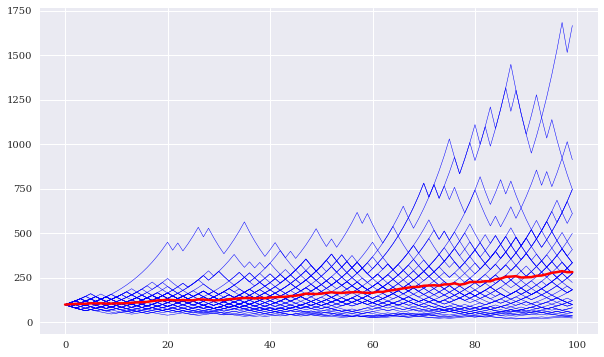

In [19]:
c_1 = run_simulation(f)
c_1.round(2)
plt.figure(figsize=(10,6))
plt.plot(c_1, 'b', lw=0.5)
plt.plot(c_1.mean(axis=1), 'r', lw=2.5)

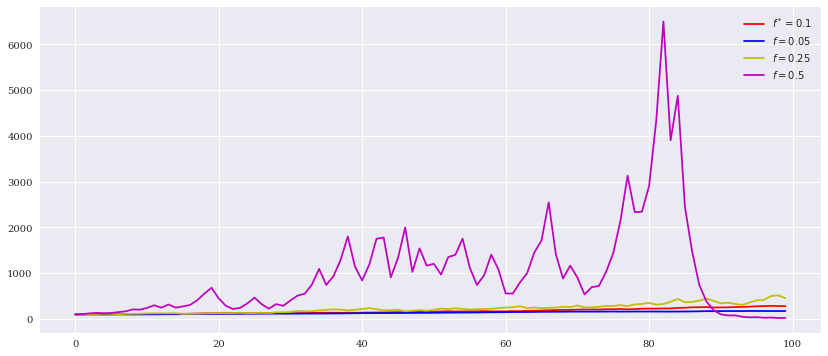

In [25]:
c_2 = run_simulation(0.05)
c_3 = run_simulation(0.25)
c_4 = run_simulation(0.5)
plt.figure(figsize=(14,6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0)

In [33]:

df = yf.download('^NSEI', '2010-01-01', '2021-07-08' )
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0
...,...,...,...,...,...,...
2021-07-01,15755.049805,15755.549805,15667.049805,15680.000000,15680.000000,224900
2021-07-02,15705.849609,15738.349609,15635.950195,15722.200195,15722.200195,254800
2021-07-05,15793.400391,15845.950195,15762.049805,15834.349609,15834.349609,207000


In [34]:
df['return'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.dropna(inplace = True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2021-07-01,15755.049805,15755.549805,15667.049805,15680.000000,15680.000000,224900,-0.002643
2021-07-02,15705.849609,15738.349609,15635.950195,15722.200195,15722.200195,254800,0.002688
2021-07-05,15793.400391,15845.950195,15762.049805,15834.349609,15834.349609,207000,0.007108
2021-07-06,15813.750000,15914.200195,15801.000000,15818.250000,15818.250000,391400,-0.001017
2021-07-07,15819.599609,15893.549805,15779.700195,15879.650391,15879.650391,329300,0.003874


In [35]:
mu = df['return'].mean()*252
mu

0.09924514147947479

In [36]:
sigma = df['return'].std()*252**0.5
sigma

0.1764068796227878

In [37]:
r = 0.0
f = (mu - r) / sigma**2
f

3.1891740319630495

In [38]:
equs = []
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    df[equ] = 1
    df[cap] = df[equ]*f
    for i, t in enumerate(df.index[1:]):
        t_1 = df.index[i]
        df.loc[t, cap] = df[cap].loc[t_1] * math.exp(df['return'].loc[t])
        df.loc[t, equ] = df[cap].loc[t] - df[cap].loc[t_1] + df[equ].loc[t_1]
        df.loc[t, cap] = df[equ].loc[t] * f

kelly_strategy(f*0.5)
kelly_strategy(f*0.66)
kelly_strategy(f)
print(df[equs].tail())

            equity_1.59  equity_2.10  equity_3.19
Date                                             
2021-07-01     4.805837     6.564346     9.253072
2021-07-02     4.826462     6.601532     9.332492
2021-07-05     4.881360     6.700650     9.544797
2021-07-06     4.873446     6.686310     9.513847
2021-07-07     4.903611     6.740939     9.631620


<AxesSubplot:xlabel='Date'>

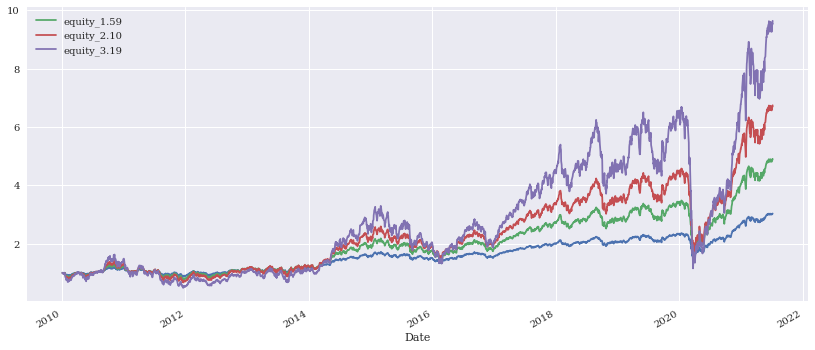

In [39]:
ax = df['return'].cumsum().apply(np.exp).plot(figsize=(14,6))
df[equs].plot(ax=ax, legend = True)